<a href="https://colab.research.google.com/github/Van314159/RL/blob/main/A2C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learn Book "Grokking RL"
-2025-06-23

Implement GAE to Synchronous Advantage Actor-Critic (A2C)—on the CartPole-v1 environment from OpenAI Gym.

In [ ]:
import numpy as np
import gymnasium as gym
from gym import spaces
import random
import matplotlib.pyplot as plt
from statistics import mean # For mean reward logging
import pickle # For saving/loading the best episode trajectory
from collections import deque
import collections
from torch.utils.tensorboard import SummaryWriter
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from torch.distributions import Categorical
import os

from google.colab import drive
drive.mount('/content/drive')
DIR = "/content/drive/My Drive/TensorBoard"


Mounted at /content/drive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
import matplotlib.pylab as pylab
from IPython.display import display
from IPython.display import HTML

plt.style.use('default')

def plot_learning_curve(xvals, yvals, label='Reward', title='Training Progress'):
    plt.plot(xvals, yvals, label=label, marker='o', linestyle='-')
    plt.title(title)
    plt.xlabel('Episode')
    plt.ylabel(label)
    plt.legend()
    plt.tight_layout()
    plt.grid()
    plt.show()

In [ ]:
class PopArtLayer(nn.Module):
    """
    Implements PopArt normalization for the critic's output.
    Maintains running statistics (mu, sigma) of the targets and adjusts
    its internal linear layer's weights/bias to preserve unnormalized outputs.
    """
    def __init__(self, input_features: int, beta: float = 0.99999):
        """
        Args:
            input_features: Dimension of the input features to this layer (i.e.,
                            the output dimension of the critic's last hidden layer).
            beta: Decay rate for the running mean and variance statistics.
        """
        super().__init__()
        self.input_features = input_features
        self.beta = beta

        # Running mean and standard deviation (buffers so they are saved with model)
        self.register_buffer('mu', torch.zeros(1, dtype=torch.float32))
        self.register_buffer('sigma', torch.ones(1, dtype=torch.float32))
        self.register_buffer('epsilon', torch.tensor(1e-8, dtype=torch.float32)) # For numerical stability

        # Learnable parameters for the final linear transformation (normalized space)
        # These will be directly optimized by the Adam optimizer
        self.weight = nn.Parameter(torch.Tensor(1, input_features))
        self.bias = nn.Parameter(torch.Tensor(1))

        self.reset_parameters()

    def reset_parameters(self):
        """Initializes the learnable weights and bias."""
        nn.init.orthogonal_(self.weight)
        nn.init.constant_(self.bias, 0.)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Performs the linear transformation. The output is the NORMALIZED value.
        Args:
            x: Input features from the critic's last hidden layer.
        Returns:
            Normalized value prediction.
        """
        normalized_output = F.linear(x, self.weight, self.bias)
        return normalized_output

    def update_statistics(self, targets: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Updates the running mean (mu) and standard deviation (sigma) based on
        a new batch of unnormalized targets (e.g., GAE returns).
        Crucially, it returns the *old* mu and sigma for the 'POP' step.

        Args:
            targets: The unnormalized target values (e.g., GAE returns).
                     Expected shape: (batch_size,).

        Returns:
            A tuple (old_mu, old_sigma) before the update.
        """
        targets = targets.float() # Ensure float type

        # Store old statistics before updating
        old_mu = self.mu.clone().detach()
        old_sigma = self.sigma.clone().detach()

        # Calculate batch mean and variance
        batch_mean = targets.mean()
        batch_variance = targets.var(unbiased=False) # Population variance

        # Update running mean and variance using exponential moving average
        new_mu = self.beta * old_mu + (1. - self.beta) * batch_mean
        new_sigma_sq = self.beta * old_sigma.pow(2) + (1. - self.beta) * batch_variance + \
                       (1. - self.beta) * self.beta * (old_mu - batch_mean).pow(2)

        self.mu.data = new_mu
        self.sigma.data = torch.sqrt(new_sigma_sq.clamp(min=self.epsilon)) # Clamp for stability

        return old_mu, old_sigma

    def normalize(self, x: torch.Tensor) -> torch.Tensor:
        """Normalizes an unnormalized value x using current running statistics."""
        return (x - self.mu) / self.sigma

    def unnormalize(self, x_normalized: torch.Tensor) -> torch.Tensor:
        """Unnormalizes a normalized value x_normalized using current running statistics."""
        return x_normalized * self.sigma + self.mu


In [ ]:
# --- ActorCriticShared Network Class ---
import torch.distributions

class ActorCriticShared(nn.Module):
    def __init__(self, input_dim: int, action_dim: int,
                 shared_hidden_dims=(64, 64),
                 actor_head_dims=(),
                 critic_head_dims=(),
                 policy_init_std: float = 1.0):
        super().__init__()

        self.input_dim = input_dim
        self.action_dim = action_dim
        self.policy_init_std = policy_init_std

        print(f"\n--- ActorCriticShared Initialization ---")
        print(f"  Input Dim (expected state features): {input_dim}")
        print(f"  Action Dim: {action_dim}")
        print(f"  Shared Hidden Dims: {shared_hidden_dims}")
        print(f"  Actor Head Dims: {actor_head_dims}")
        print(f"  Critic Head Dims: {critic_head_dims}")


        # --- Shared Layers (Trunk) ---
        shared_layers = []
        last_shared_dim = input_dim
        for dim in shared_hidden_dims:
            shared_layers.append(nn.Linear(last_shared_dim, dim))
            shared_layers.append(nn.ReLU()) # Assuming ReLU as per typical A2C
            last_shared_dim = dim
        self.shared_net = nn.Sequential(*shared_layers)

        print(f"  Shared Layers Output Dim: {last_shared_dim}")

        # --- Actor Head ---
        actor_layers = []
        last_actor_dim = last_shared_dim
        for dim in actor_head_dims:
            actor_layers.append(nn.Linear(last_actor_dim, dim))
            actor_layers.append(nn.ReLU())
            last_actor_dim = dim

        # Final actor layer
        self.actor_head_output = nn.Linear(last_actor_dim, action_dim)
        nn.init.normal_(self.actor_head_output.weight, mean=0., std=0.01) # Small std for initial exploration
        nn.init.constant_(self.actor_head_output.bias, 0.)

        actor_layers.append(self.actor_head_output)
        self.actor_head = nn.Sequential(*actor_layers)




        # --- Critic Head ---
        critic_layers = []
        last_critic_dim = last_shared_dim
        for dim in critic_head_dims:
            critic_layers.append(nn.Linear(last_critic_dim, dim))
            nn.init.normal_(self.critic_layers[-1].weight, mean=0.0, std=1.0) # Bias must start positive
            nn.init.constant_(self.critic_layers[-1].bias, 0.)
            critic_layers.append(nn.ReLU())
            last_critic_dim = dim


        self.critic_head = nn.Sequential(*critic_layers)

        # Add PopArt Layer to rescale value.
        self.critic_popart_layer = PopArtLayer(input_features=last_critic_dim)


    def forward(self, x):
        shared_features = self.shared_net(x)
        actor_logits = self.actor_head(shared_features)

        critical_hidden_features = self.critic_head(shared_features)
        value_normalized = self.critic_popart_layer(critical_hidden_features)
        value_unnormalized = self.critic_popart_layer.unnormalize(value_normalized)
        return actor_logits, value_normalized, value_unnormalized

    def full_pass(self, states):
        actor_logits, _, value_unnormalized = self.forward(states)
        dist = torch.distributions.Categorical(logits=actor_logits)
        actions = dist.sample()
        log_probs = dist.log_prob(actions)
        entropies = dist.entropy()
        return actions.cpu().numpy(), log_probs, entropies, value_unnormalized.squeeze(-1)

In [ ]:
test_env = gym.make('CartPole-v1')

state_dim = test_env.observation_space.shape[0]
action_dim = test_env.action_space.n
obs, _ = test_env.reset()
obs

array([-0.03896194, -0.04872777,  0.03406781, -0.0197865 ], dtype=float32)

In [ ]:
def make_cartpole_env():
        # This creates ONE CartPole-v1 environment.
        return gym.make('CartPole-v1', render_mode='rgb_array')

ENV_MAKE_FN = make_cartpole_env
print(f"Using environment make function: {ENV_MAKE_FN.__name__}")

Using environment make function: make_cartpole_env


In [ ]:
actor_critic_test_net = ActorCriticShared(
        input_dim=state_dim,
        action_dim=action_dim,
        shared_hidden_dims=SHARED_HIDDEN_DIMS,
        actor_head_dims=ACTOR_HEAD_DIMS,
        critic_head_dims=CRITIC_HEAD_DIMS,
        policy_init_std=POLICY_INIT_STD
    ).to(device)

NameError: name 'SHARED_HIDDEN_DIMS' is not defined

In [ ]:
test_state_tensor = torch.tensor(obs, dtype=torch.float32).to(device)
test_state_tensor

tensor([-0.0390, -0.0487,  0.0341, -0.0198], device='cuda:0')

In [ ]:
try:
    action, log_prob, entropy, value = actor_critic_test_net.full_pass(test_state_tensor)

    print(f"\n--- Network Output (Test) ---")
    print(f"  Action (item): {action}")
    print(f"  Log Prob (scalar tensor): {log_prob}")
    print(f"  Entropy (scalar tensor): {entropy}")
    print(f"  Value (scalar): {value}")
    print(f"  Log Prob shape: {log_prob.shape}") # Should be torch.Size([])
    print(f"  Entropy shape: {entropy.shape}")   # Should be torch.Size([])

    print("\nTest successful! Network processed a standard CartPole observation.")
    print("This suggests the problem lies in how the `state` variable is handled or modified within your *main training loop* before being passed to the network, causing it to sometimes become `torch.Size([20])`.")

except Exception as e:
    print(f"\n!!! Test Failed !!!")
    print(f"An error occurred during network full_pass: {e}")
    import traceback
    traceback.print_exc()

finally:
    test_env.close()


!!! Test Failed !!!
An error occurred during network full_pass: name 'actor_critic_test_net' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-10-3752008368.py", line 2, in <cell line: 0>
    action, log_prob, entropy, value = actor_critic_test_net.full_pass(test_state_tensor)
                                       ^^^^^^^^^^^^^^^^^^^^^
NameError: name 'actor_critic_test_net' is not defined


# --- A2CTrainer Class (Modified) + PopArt ---

In [ ]:
# --- A2CTrainer Class (Modified) ---
from gymnasium.vector import SyncVectorEnv
from datetime import datetime
import pytz


class A2CTrainer:
    def __init__(self, env_make_fn, gamma: float=0.99, entropy_beta: float=0.001,
                 n_steps: int=5, max_grad_norm: float=1.0,
                 num_episodes: int = 1000, print_interval: int = 50,
                 device='cpu', num_envs=4,
                 debug_mode: bool = False, gae_lambda: float = 0.95,
                 lr: float = 1e-4, # Single learning rate for combined optimizer
                 shared_hidden_dims=(64,64),
                 actor_head_dims=(),
                 critic_head_dims=(),
                 policy_init_std: float = 1.0):

        # --- Environment Setup (Always use SyncVectorEnv with explicit make_fn) ---
        self.num_envs = num_envs

        # This is the robust way to create vectorized environments
        self.env = SyncVectorEnv(
            [env_make_fn for _ in range(self.num_envs)]
        )

        # Try to get the environment ID from the first created single environment
        # Create a temporary single environment just to get its spec.id
        # Ensure that env_make_fn provides a 'close' method or context manager if needed.
        with env_make_fn() as temp_env: # Using 'with' for auto-closing if temp_env supports it
            self.env_spec_id = getattr(temp_env.spec, 'id', 'CustomEnvFunc')


        self.gamma = gamma
        self.entropy_beta = entropy_beta
        self.n_steps = n_steps
        self.max_grad_norm = max_grad_norm
        self.num_episodes = num_episodes
        self.print_interval = print_interval
        self.debug_mode = debug_mode
        self.gae_lambda = gae_lambda
        self.device = device

        # Networks: Instantiate the single shared ActorCriticShared network
        state_dim = self.env.single_observation_space.shape[0]
        action_dim = self.env.single_action_space.n

        self.actor_critic_net = ActorCriticShared(
            input_dim=state_dim,
            action_dim=action_dim,
            shared_hidden_dims=shared_hidden_dims,
            actor_head_dims=actor_head_dims,
            critic_head_dims=critic_head_dims,
            policy_init_std=policy_init_std
        ).to(self.device)

        # Optimizer: A single optimizer for all parameters of the combined network
        self.optimizer = torch.optim.Adam(self.actor_critic_net.parameters(), lr=lr)

        # --- TensorBoard Setup ---
        tokyo = pytz.timezone('Asia/Tokyo')
        timestamp = datetime.now(tokyo).strftime('%Y%m%d-%H%M')
        log_dir = os.path.join(DIR, f"{timestamp}_{self.env_spec_id}")
        os.makedirs(log_dir, exist_ok=True)
        self.writer = SummaryWriter(log_dir)
        self.total_train_steps = 0 # Counter for overall training steps/updates
        print(f"TensorBoard logs being written to: {log_dir}")

        # Buffers for collecting n_steps experiences
        self.segment_states = []
        self.segment_actions = []
        self.segment_rewards = []
        self.segment_log_probs = []
        self.segment_values = []
        self.segment_entropies = []

        # Episode tracking for multiple environments
        self.current_episode_rewards = np.zeros(self.num_envs, dtype=np.float32) # Tracks cumulative reward for current episodes in each env
        self.current_episode_lengths = np.zeros(self.num_envs, dtype=int)

        self.total_episodes_finished = 0 # Overall counter for finished episodes across all envs
        self.episode_rewards_deque = deque(maxlen=100) # Stores rewards of completed episodes

        self.training_complete = False


    def train(self):
        current_states_np, _ = self.env.reset() # list of obs.
        current_states_tensor = torch.as_tensor(current_states_np, dtype=torch.float32, device=self.device)
        #print(f"Initial state shape after env.reset(): {state.shape}")
        total_reward_for_current_episode = 0

        while not self.training_complete and self.total_episodes_finished < self.num_episodes:
            self.segment_states.clear()
            self.segment_actions.clear()
            self.segment_rewards.clear()
            self.segment_log_probs.clear()
            self.segment_values.clear()
            self.segment_entropies.clear()

            segment_terminated = False
            segment_truncated = False

            for step_idx in range(self.n_steps):
                # list with env_nums.
                actions_np, log_probs_tensor, entropies_tensor, values_unnormalized_tensor = \
                    self.actor_critic_net.full_pass(current_states_tensor)

                # Perform step in the vectorized environment
                # Synchronous update of all env.
                next_states_np, rewards_np, terminateds_np, truncateds_np, _ = self.env.step(actions_np)

                # Store data for this step (batch) into segment buffers
                self.segment_states.append(current_states_tensor) # Store the state *before* action
                self.segment_actions.append(torch.as_tensor(actions_np, dtype=torch.long, device=self.device)) # Store actions
                self.segment_rewards.append(torch.as_tensor(rewards_np, dtype=torch.float32, device=self.device))
                self.segment_log_probs.append(log_probs_tensor)
                self.segment_values.append(values_unnormalized_tensor)
                self.segment_entropies.append(entropies_tensor)

                # Update total reward and length for *each* currently active episode
                self.current_episode_rewards += rewards_np
                self.current_episode_lengths += 1

                # Handle environments that finished (terminated or truncated)
                dones_np = terminateds_np | truncateds_np
                for env_idx, done in enumerate(dones_np):
                    if done:
                        # An episode in environment `env_idx` has finished
                        self.total_episodes_finished += 1
                        self.episode_rewards_deque.append(self.current_episode_rewards[env_idx])


                        # Check for environment solved condition (e.g., for CartPole-v1)
                        if self.env_spec_id == 'CartPole-v1' and np.mean(list(self.episode_rewards_deque)) >= 475:
                            print(f"Environment {self.env_spec_id} solved at {self.total_episodes_finished} episodes!")
                            self.training_complete = True

                            break

                        # Reset the current episode tracking for this specific environment
                        self.current_episode_rewards[env_idx] = 0.0
                        self.current_episode_lengths[env_idx] = 0

                # If not done, continue episode.
                # This must be done AFTER checking for 'done' states as 'next_states_np' from env.step
                current_states_tensor = torch.as_tensor(next_states_np, dtype=torch.float32, device=self.device)

                # If overall training is complete (e.g., solved), break from step collection loop
                if self.training_complete:
                    break

            # If training completed during segment collection, no need to update networks
            if self.training_complete:
                break

            # Episode collected. Begin to update the net.
            # Calculate the value of the next state for GAE for *all* environments
            # Use the 'current_states_tensor' which holds the states after the last step of the segment
            # For environments that terminated/truncated, their next value for GAE will be 0.

            final_next_values_for_gae = torch.zeros(self.num_envs, dtype=torch.float32, device=self.device)
            # Only get value from network for environments that are NOT done
            non_done_indices = torch.tensor(~dones_np).nonzero(as_tuple=True)[0]
            if len(non_done_indices) > 0:
                # Get the states for only the non-done environments
                states_for_final_value = current_states_tensor[non_done_indices]
                # calculate the value of finial state
                _, _, final_value_raw_unnormalized = self.actor_critic_net(states_for_final_value)
                final_next_values_for_gae[non_done_indices] = final_value_raw_unnormalized.squeeze(-1).detach()


            # Calculate GAE advantages and returns using the new batched GAE function
            gae_advantages_unnormalized, gae_returns_unnormalized = self._calculate_gae_batched(
                self.segment_rewards,     # list of tensors, each (num_envs,)
                self.segment_values,      # list of tensors, each (num_envs,)
                final_next_values_for_gae, # tensor (num_envs,)
                dones_np,                 # numpy array (num_envs,)
                self.gamma, self.gae_lambda
            )

            # Stack all collected segment data into full batches for the update_networks function
            # These will be of shape (n_steps * num_envs, feature_dim) or (n_steps * num_envs,)
            all_states_batch = torch.cat(self.segment_states)
            all_log_probs_batch = torch.cat(self.segment_log_probs)
            all_entropies_batch = torch.cat(self.segment_entropies)

            # Pass all collected batches to update_networks
            policy_loss, value_loss, entropy_loss = self.update_networks(
                all_states_batch,
                all_log_probs_batch,
                all_entropies_batch,
                gae_returns_unnormalized,      # gae_returns are already flattened to (n_steps * num_envs,)
                gae_returns_unnormalized    # gae_advantages are already flattened to (n_steps * num_envs,)
            )

            self.total_train_steps += 1
            self.writer.add_scalar("Loss/Policy", policy_loss, self.total_train_steps)
            self.writer.add_scalar("Loss/Value", value_loss, self.total_train_steps)
            self.writer.add_scalar("Loss/Entropy", entropy_loss, self.total_train_steps)


            # Print loss updates only if we updated
            #if self.total_episodes_finished > 1 and self.total_episodes_finished % self.print_interval == 0: # Avoid double-printing if episode also finished
            if self.total_train_steps > 1 and self.total_train_steps % self.print_interval == 0:
                print(f"Segment Update | Total Episodes: {self.total_episodes_finished}/{self.num_episodes} | P_Loss: {policy_loss:.4f} | V_Loss: {value_loss:.4f} | E_Loss: {entropy_loss:.4f}")
                avg_reward = np.mean(list(self.episode_rewards_deque))
                print(f"Total Train Step Finished: {self.total_train_steps}/{self.num_episodes} | Avg Reward (last {len(self.episode_rewards_deque)} episodes): {avg_reward:.2f}")
                self.writer.add_scalar("Reward/Average (Last 100 Episodes)", avg_reward, self.total_episodes_finished)
        self.env.close()
        self.writer.close()
        print("Training finished.")

    def _calculate_gae_single_trajectory(self, rewards, values, next_state_value_detached, gamma, gae_lambda):
        # This helper function remains the same
        gae_advantages = []
        returns = []
        gae = 0.0

        for i in reversed(range(len(rewards))):
            reward = rewards[i]
            current_value = values[i]

            if i == len(rewards) - 1:
                next_value = next_state_value_detached
            else:
                next_value = values[i+1]

            delta = reward + gamma * next_value - current_value

            gae = delta + gamma * gae_lambda * gae
            gae_advantages.insert(0, gae)

            returns.insert(0, gae + current_value)

        return torch.tensor(gae_advantages, dtype=torch.float32).to(self.device), \
               torch.tensor(returns, dtype=torch.float32).to(self.device)

    def _calculate_gae_batched(self, segment_rewards, segment_values, final_next_values_all_envs, dones_at_end_of_segment, gamma, gae_lambda):

        # segment_rewards: list of Tensors, each (num_envs,)
        # segment_values: list of Tensors, each (num_envs,)
        # final_next_values_all_envs: Tensor (num_envs,)
        # dones_at_end_of_segment: np array (num_envs,) - True if env terminated/truncated at last step of segment

        num_steps = len(segment_rewards) # This is self.n_steps
        num_envs = segment_rewards[0].shape[0]

        all_gae_advantages = []
        all_gae_returns = []

        for env_idx in range(num_envs):
            # Extract data for this single environment's trajectory
            rewards_env = [reward_batch[env_idx].item() for reward_batch in segment_rewards] # Convert to Python list of floats
            values_env = [value_batch[env_idx].detach() for value_batch in segment_values] # List of detached scalar tensors

            # The next value for this specific environment
            next_value_env = final_next_values_all_envs[env_idx]

            # If this specific environment finished its episode in the last step of the segment,
            # its true next_state_value for GAE is 0.
            if dones_at_end_of_segment[env_idx]:
                next_value_env = torch.tensor(0.0, dtype=torch.float32).to(self.device) # Explicitly set to 0.0 tensor

            # Calculate GAE for this single environment's trajectory
            advantages, returns = self._calculate_gae_single_trajectory(
                rewards_env,
                values_env,
                next_value_env,
                gamma,
                gae_lambda
            )
            all_gae_advantages.append(advantages)
            all_gae_returns.append(returns)

        # Concatenate all advantages and returns into single 1D tensors
        # Each element in all_gae_advantages/returns is (n_steps,)
        # Result will be (num_envs * n_steps,)
        final_advantages = torch.cat(all_gae_advantages)
        final_returns = torch.cat(all_gae_returns)

        return final_advantages, final_returns


    def update_networks(self, all_states_batch: torch.Tensor, all_log_probs_batch: torch.Tensor,
                        all_entropies_batch: torch.Tensor,
                        gae_returns_unnormalized: torch.Tensor, gae_advantages_unnormalized: torch.Tensor):

        # DEBUG: Store initial parameters if debug_mode is on
        if self.debug_mode:
            initial_params = {name: param.clone() for name, param in self.actor_critic_net.named_parameters()}
            print(f"all states: {all_states_batch}")

        # Update Popart layer.
        old_mu, old_sigma = self.actor_critic_net.critic_popart_layer.update_statistics(gae_returns_unnormalized)

        new_mu = self.actor_critic_net.critic_popart_layer.mu
        new_sigma = self.actor_critic_net.critic_popart_layer.sigma

        self.actor_critic_net.critic_popart_layer.weight.data = \
            self.actor_critic_net.critic_popart_layer.weight.data * (old_sigma / new_sigma)
        self.actor_critic_net.critic_popart_layer.bias.data = \
            (self.actor_critic_net.critic_popart_layer.bias.data - old_mu) / new_sigma * old_sigma + new_mu


        actor_logits, predicted_values_normalized, predicted_values_unnormalized = \
            self.actor_critic_net(all_states_batch)
        predicted_values_normalized = predicted_values_normalized.squeeze(-1)
        gae_returns_normalized = self.actor_critic_net.critic_popart_layer.normalize(gae_returns_unnormalized)

        # Compute log_probs and entropies for the entire batch
        dist = torch.distributions.Categorical(logits=actor_logits)


        policy_loss = - (all_log_probs_batch * gae_advantages_unnormalized).mean()
        value_loss = F.mse_loss(predicted_values_normalized, gae_returns_normalized)
        entropy_loss_val = all_entropies_batch.mean() # Store the raw entropy mean for clear debugging
        entropy_loss = - self.entropy_beta * entropy_loss_val

        total_loss = policy_loss +  0.5 * value_loss + entropy_loss

        # --- DEBUG Prints Added Here ---
        if self.debug_mode:
            print(f"\n--- Debug Update Networks ---")
            print(f"Policy Loss: {policy_loss.item():.6f}")
            print(f"Value Loss (Normalized): {value_loss.item():.6f}") # Indicate it's on normalized values
            print(f"Entropy Beta: {self.entropy_beta}")
            print(f"Raw Entropy Mean (all_entropies_batch.mean()): {entropy_loss_val.item():.6f}")
            print(f"Entropy Loss (weighted): {entropy_loss.item():.6f}")
            print(f"Total Loss: {total_loss.item():.6f}")

            print(f"\n--- PopArt Statistics ---")
            print(f"  Old Mu: {old_mu.item():.4f}, Old Sigma: {old_sigma.item():.4f}")
            print(f"  New Mu: {self.actor_critic_net.critic_popart_layer.mu.item():.4f}, New Sigma: {self.actor_critic_net.critic_popart_layer.sigma.item():.4f}")

            print(f"\n--- Value Comparisons ---")
            print(f"Predicted Values (Normalized): {predicted_values_normalized.min().item():.4f} to {predicted_values_normalized.max().item():.4f}, Mean: {predicted_values_normalized.mean().item():.4f}, Std: {predicted_values_normalized.std().item():.4f}")
            print(f"Target GAE Returns (Normalized): {gae_returns_normalized.min().item():.4f} to {gae_returns_normalized.max().item():.4f}, Mean: {gae_returns_normalized.mean().item():.4f}, Std: {gae_returns_normalized.std().item():.4f}")
            print(f"Predicted Values (UNnormalized): {predicted_values_unnormalized.min().item():.4f} to {predicted_values_unnormalized.max().item():.4f}, Mean: {predicted_values_unnormalized.mean().item():.4f}, Std: {predicted_values_unnormalized.std().item():.4f}")
            print(f"Target GAE Returns (UNnormalized): {gae_returns_unnormalized.min().item():.4f} to {gae_returns_unnormalized.max().item():.4f}, Mean: {gae_returns_unnormalized.mean().item():.4f}, Std: {gae_returns_unnormalized.std().item():.4f}")

            print(f"\n--- GAE Stats (Unnormalized) ---")
            print(f"GAE Advantages - Min: {gae_advantages_unnormalized.min().item():.6f}, Max: {gae_advantages_unnormalized.max().item():.6f}, Mean: {gae_advantages_unnormalized.mean().item():.6f}, Std: {gae_advantages_unnormalized.std().item():.6f}")
            print(f"GAE Returns - Min: {gae_returns_unnormalized.min().item():.6f}, Max: {gae_returns_unnormalized.max().item():.6f}, Mean: {gae_returns_unnormalized.mean().item():.6f}, Std: {gae_returns_unnormalized.std().item():.6f}")

            sample_size = actor_logits.shape[0]
            print(f"\nSampled Actor Logits (first {min(5, sample_size)}):")
            print(actor_logits[:min(5, sample_size)].detach().cpu().numpy())
            print(f"Sampled Policy Probs (first {min(5, sample_size)}):")
            print(dist.probs[:min(5, sample_size)].detach().cpu().numpy())
            print(f"--- End Debug Update Networks ---\n")


        # --- Zero gradients, compute, clip, and step for the combined network ---
        self.optimizer.zero_grad()
        total_loss.backward()

        # DEBUG: Check gradients before optimization step
        if self.debug_mode:
            non_zero_grad_count = 0
            total_params = 0
            for name, param in self.actor_critic_net.named_parameters():
                if param.grad is not None:
                    total_params += 1
                    if param.grad.norm().item() > 1e-6: # Check if gradient norm is significantly non-zero
                        non_zero_grad_count += 1
                        print(f"DEBUG: grad norm: {param.grad.norm()}")
                else:
                    print(f"DEBUG: Parameter {name} has no gradient.")
            if total_params > 0:
                print(f"DEBUG: {non_zero_grad_count}/{total_params} parameters have non-zero gradients before step.")
            else:
                print("DEBUG: No parameters found with gradients.")

        torch.nn.utils.clip_grad_norm_(self.actor_critic_net.parameters(), self.max_grad_norm)
        self.optimizer.step()

        # DEBUG: Compare parameters after optimization step
        if self.debug_mode:
            params_updated_count = 0
            for name, param in self.actor_critic_net.named_parameters():
                if name in initial_params:
                    if not torch.equal(initial_params[name], param):
                        params_updated_count += 1
                        # Optional: Print detailed diff for a few parameters
                        # if params_updated_count < 5: # Limit output to avoid spam
                        #     print(f"  Parameter '{name}' updated. Norm diff: {(initial_params[name] - param).norm().item()}")
            print(f"DEBUG: {params_updated_count}/{len(initial_params)} parameters updated after optimizer step.")
            if params_updated_count == 0 and len(initial_params) > 0:
                print("WARNING: No network parameters were updated. This might indicate an issue with gradients or learning rate.")


        # Clear segment buffers for the next collection phase
        self.segment_states.clear()
        self.segment_actions.clear()
        self.segment_rewards.clear()
        self.segment_log_probs.clear()
        self.segment_values.clear()
        self.segment_entropies.clear()

        return policy_loss.item(), value_loss.item(), entropy_loss.item()


In [ ]:
# Hyperparameters
ENV_NAME = 'CartPole-v1'
GAMMA = 0.99
GAE_LAMBDA = 0.95
ENTROPY_BETA = 0.001
N_STEPS = 10
MAX_GRAD_NORM = 1.0 # Single grad norm for the combined network
NUM_EPISODES = 1000000
PRINT_INTERVAL = 500
DEBUG_MODE = True
LR = 1e-4 # Single learning rate for the combined optimizer

# Network architecture for the shared base and heads
SHARED_HIDDEN_DIMS = (256, 128)
ACTOR_HEAD_DIMS = () # No additional layers after shared for actor
CRITIC_HEAD_DIMS = () # No additional layers after shared for critic
POLICY_INIT_STD = 1.0

In [ ]:
env = SyncVectorEnv(
            [ENV_MAKE_FN for _ in range(3)]
        )
obs, _ = env.reset()
obs_tensor = torch.as_tensor(obs, dtype=torch.float32)

actions_np, log_probs_tensor, entropies_tensor, values_tensor = actor_critic_test_net.full_pass(obs_tensor)
# next_states_np, rewards_np, terminateds_np, truncateds_np, _ = self.env.step(actions_np)
env.step(actions_np)

NameError: name 'actor_critic_test_net' is not defined

In [ ]:
# Create environment

# Instantiate A2C Trainer with shared network
trainer = A2CTrainer(
    env_make_fn=ENV_MAKE_FN,
    gamma=GAMMA,
    num_envs=8,
    entropy_beta=ENTROPY_BETA,
    n_steps=N_STEPS,
    max_grad_norm=MAX_GRAD_NORM,
    num_episodes=NUM_EPISODES,
    print_interval=PRINT_INTERVAL,
    debug_mode=False,
    gae_lambda=0.0,
    lr=LR, # Pass single LR
    shared_hidden_dims=SHARED_HIDDEN_DIMS,
    actor_head_dims=ACTOR_HEAD_DIMS,
    critic_head_dims=CRITIC_HEAD_DIMS,
    policy_init_std=POLICY_INIT_STD
)

# Start training
trainer.train()


--- ActorCriticShared Initialization ---
  Input Dim (expected state features): 4
  Action Dim: 2
  Shared Hidden Dims: (256, 128)
  Actor Head Dims: ()
  Critic Head Dims: ()
  Shared Layers Output Dim: 128
TensorBoard logs being written to: /content/drive/My Drive/TensorBoard/20250624-2213_CartPole-v1
Segment Update | Total Episodes: 1923/1000000 | P_Loss: 7.8937 | V_Loss: 1.5064 | E_Loss: -0.0006
Total Train Step Finished: 500/1000000 | Avg Reward (last 100 episodes): 14.33
Segment Update | Total Episodes: 5291/1000000 | P_Loss: 1.9493 | V_Loss: 0.4215 | E_Loss: -0.0001
Total Train Step Finished: 1000/1000000 | Avg Reward (last 100 episodes): 9.29
Segment Update | Total Episodes: 9160/1000000 | P_Loss: 0.0029 | V_Loss: 0.0664 | E_Loss: -0.0000
Total Train Step Finished: 1500/1000000 | Avg Reward (last 100 episodes): 9.52
Segment Update | Total Episodes: 13017/1000000 | P_Loss: 0.0009 | V_Loss: 3.3796 | E_Loss: -0.0000
Total Train Step Finished: 2000/1000000 | Avg Reward (last 100 e

KeyboardInterrupt: 

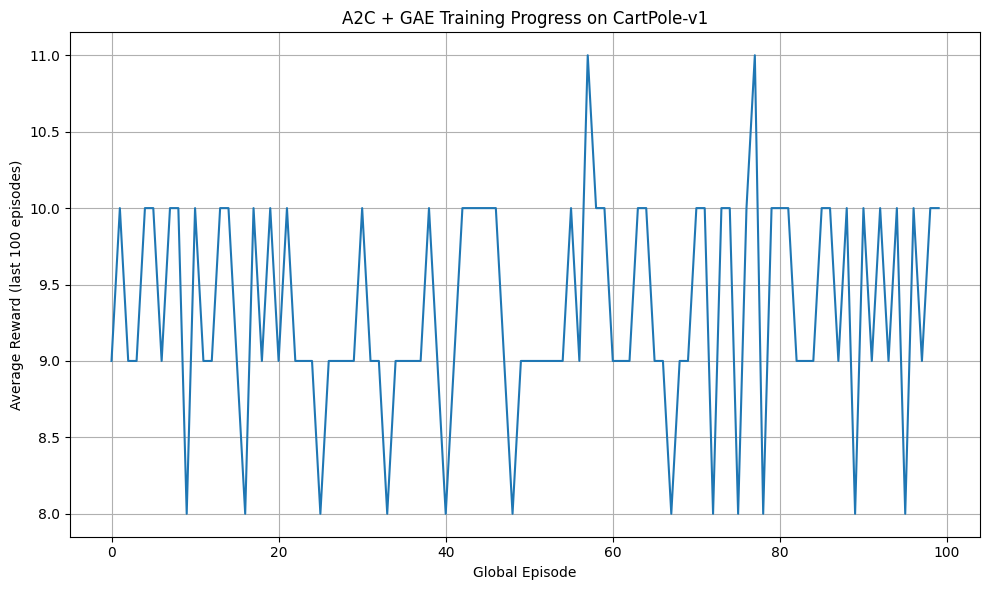

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(np.arange(len(trainer.episode_rewards_deque)), list(trainer.episode_rewards_deque), linestyle='-')
plt.xlabel("Global Episode")
plt.ylabel(f"Average Reward (last 100 episodes)")
plt.title(f"A2C + GAE Training Progress on {ENV_NAME}")
plt.grid(True)
plt.tight_layout()
plt.show()

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
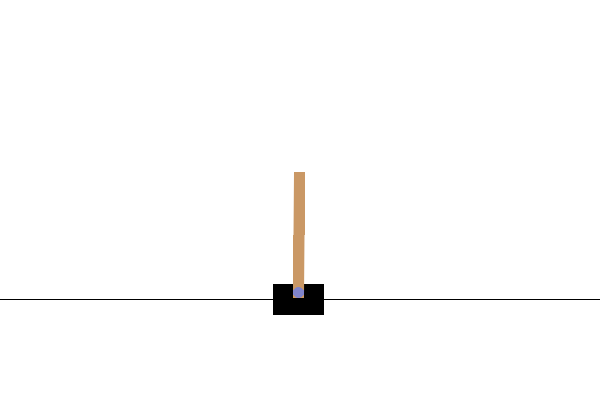

In [ ]:
eval_env = gym.make(ENV_NAME, render_mode="rgb_array")
eval_env.reset()
eval_env.render()

In [ ]:
# @title
eval_rewards = []
EVAL_EPISODES = 100
trainer.actor_critic_net.eval()

# Disable gradient calculations for efficiency during evaluation
with torch.no_grad():
    for episode in range(EVAL_EPISODES):
        state, _ = eval_env.reset()
        episode_reward = 0
        done = False
        truncated = False

        while not done and not truncated:
            # Get the greedy action from the global policy network
            # Move state to device if necessary (though full_pass handles it)
            state_tensor = torch.as_tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            actor_logits, _ = trainer.actor_critic_net(state_tensor)
            action = torch.argmax(actor_logits, dim=-1).item()  # Select the greedy action

            next_state, reward, done, truncated, _ = eval_env.step(action)
            episode_reward += reward
            state = next_state

        eval_rewards.append(episode_reward)

        if episode % 10 == 0:
            print(f"Evaluation Episode {episode+1}/{EVAL_EPISODES}: Reward = {episode_reward}")

# Close the evaluation environment
eval_env.close()

Evaluation Episode 1/100: Reward = 500.0
Evaluation Episode 11/100: Reward = 500.0
Evaluation Episode 21/100: Reward = 500.0
Evaluation Episode 31/100: Reward = 500.0
Evaluation Episode 41/100: Reward = 500.0
Evaluation Episode 51/100: Reward = 500.0
Evaluation Episode 61/100: Reward = 500.0
Evaluation Episode 71/100: Reward = 500.0
Evaluation Episode 81/100: Reward = 500.0
Evaluation Episode 91/100: Reward = 500.0



--- Evaluation Complete ---
Average Reward over 100 episodes: 13.51
Standard Deviation of Reward: 1.55
CartPole-v1 is not yet solved (Avg Reward < 475). Keep training!


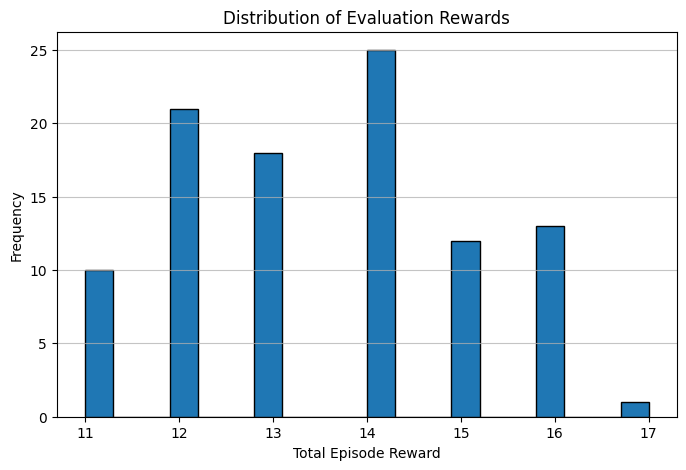

In [ ]:
avg_eval_reward = np.mean(eval_rewards)
std_eval_reward = np.std(eval_rewards)

print(f"\n--- Evaluation Complete ---")
print(f"Average Reward over {EVAL_EPISODES} episodes: {avg_eval_reward:.2f}")
print(f"Standard Deviation of Reward: {std_eval_reward:.2f}")
# Check if the environment is "solved" based on its criteria (CartPole-v1: 475)
if ENV_NAME == 'CartPole-v1':
    if avg_eval_reward >= 475:
        print(f"Congratulations! {ENV_NAME} is considered SOLVED (Avg Reward >= 475)!")
    else:
        print(f"{ENV_NAME} is not yet solved (Avg Reward < 475). Keep training!")

# Optional: Plot the distribution of evaluation rewards
plt.figure(figsize=(8, 5))
plt.hist(eval_rewards, bins=20, edgecolor='black')
plt.title('Distribution of Evaluation Rewards')
plt.xlabel('Total Episode Reward')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/drive/My Drive/TensorBoard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
2025-06-24 00:26:44.791353: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750724804.919093    4052 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750724804.950966    4052 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
usage: tensorboard [-h] [--helpfull] [--logdir PATH] [--logdir_spec PATH_SPEC]
                   [--host ADDR] [--bind_all] [--port PORT]
                   [--reuse_port BOOL] [--load_fast {false,auto,true}]
                   [--extra_data_server_flags EXTRA_DATA_SERVER_FLAGS]
                   [--grpc_creds_type {local,ssl,ssl_dev}]
                   [--gr